In [1]:
import sys
import os

CURRENT_DIR = os.path.dirname(os.path.realpath("__file__"))
BASE_DIR = os.path.join(CURRENT_DIR, os.pardir)
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")

sys.path.append(BASE_DIR)
sys.path.append(CURRENT_DIR)

from model.model import AdaptationModel, Wizard
from model import utils
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, mannwhitneyu

from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting

# sns.set_style()
# sns.set_theme(style = 'whitegrid', palette = 'deep')

plt.style.use("../model/myBmh.mplstyle")

In [2]:
# Utilities
from itertools import product, chain
import pandas as pd
import numpy as np


def calc_col_names(named_shape):
    *prefix, shape = named_shape
    names = [map(str, range(i)) for i in shape]
    return map('_'.join, product(prefix, *names))


def create_flat_columns_df_from_dict_of_numpy(
        named_np: dict[str, np.array],
        n_samples_per_np: int,
):
    flat_nps = [a.reshape(n_samples_per_np, -1) for a in named_np.values()]
    stacked_nps = np.column_stack(flat_nps)
    named_shapes = [(name, arr.shape[1:]) for name, arr in named_np.items()]
    col_names = [*chain.from_iterable(calc_col_names(named_shape) for named_shape in named_shapes)]
    df = pd.DataFrame(stacked_nps, columns=col_names)
    df = df.convert_dtypes()
    return df


    

In [3]:
## Load data

# results = load_results(os.path.join(OUTPUT_DIR, "temporary.tar.gz"))
# results = load_results(os.path.join(OUTPUT_DIR, "long.tar.gz"))
results = load_results(os.path.join(OUTPUT_DIR, "parametric-h200-t80-r100-s20.tar.gz"))
experiments, data = results

unique_policies = experiments["policy"].unique()

n_scenarios = data["TotalAdapted"].shape[0]
n_replications = data["TotalAdapted"].shape[1]
n_timesteps = data["TotalAdapted"].shape[2]
n_policies = len(unique_policies)

n_metrics = len(list(data.keys()))

print(f"Analysing {n_scenarios} scenarios, with policies {list(unique_policies)}, {n_replications} replications, {n_timesteps} timesteps")

experiments.iloc[:20]
# experiments[experiments["scenario"]==4]

Analysing 80 scenarios, with policies ['NoPolicy', 'Info', 'Subsidy', 'Info + Subsidy'], 100 replications, 80 timesteps


,avg_risk_aversion,avg_savings_per_step_vs_house,avg_trustworthiness_government,max_initial_savings,width_risk_aversion,scenario,policy,model
0,0.613531,-0.009351,0.230550,126.161568,0.469116,0,NoPolicy,AdaptationModel
1,0.515266,0.029808,0.380590,399.177882,0.927719,1,NoPolicy,AdaptationModel
2,0.654720,0.123333,0.000598,248.911420,0.620980,2,NoPolicy,AdaptationModel
3,0.417002,0.110360,0.257592,392.661893,0.906347,3,NoPolicy,AdaptationModel
4,0.454698,0.070903,0.117383,100.189562,0.881677,4,NoPolicy,AdaptationModel
5,0.726667,0.218025,0.359284,350.126480,0.985254,5,NoPolicy,AdaptationModel
6,0.489656,-0.041421,-0.096190,476.667145,0.425395,6,NoPolicy,AdaptationModel
7,0.325576,-0.034041,0.215168,203.015443,0.838924,7,NoPolicy,AdaptationModel
8,0.257715,-0.064654,0.294388,150.543128,0.514722,8,NoPolicy,AdaptationModel
9,0.560210,0.005305,0.150182,334.528102,0.388848,9,NoPolicy,AdaptationModel


In [4]:
# Usefull Dataframes
flat_dict=  {k: v.flatten() for k, v in data.items()}
df_all = pd.DataFrame(np.repeat(experiments.values, n_replications*n_timesteps, axis=0), columns=experiments.columns)
df_all["time"]= np.array([i for j in range(n_replications * n_scenarios)  for i in range(n_timesteps)])
df_all = df_all.join(pd.DataFrame(flat_dict))

# Mean of the scenarios
df_scenario_mean = df_all.groupby(["policy", "scenario", "time"])[["TotalAdapted"]].mean()

# df_all = df_all[df_all["avg_savings_per_step_vs_house"] > 0.25]
# df_all = df_all[df_all["scenario"] == 1]
# df_all.head()

df_all = df_all[df_all["scenario"].isin([0,5,6,8])]
df_all.head()

,avg_risk_aversion,avg_savings_per_step_vs_house,avg_trustworthiness_government,max_initial_savings,width_risk_aversion,scenario,policy,model,time,InformationAbundance,SocietalRisk,AverageRiskAversion,AverageEstimationFactor,TotalAdapted
0,0.613531,-0.009351,0.23055,126.161568,0.469116,0,NoPolicy,AdaptationModel,0,0.1,NaN,0.436834,0.485011,0
1,0.613531,-0.009351,0.23055,126.161568,0.469116,0,NoPolicy,AdaptationModel,1,0.1,0.025387,0.429572,0.496674,3
2,0.613531,-0.009351,0.23055,126.161568,0.469116,0,NoPolicy,AdaptationModel,2,0.1,0.025009,0.424566,0.508023,4
3,0.613531,-0.009351,0.23055,126.161568,0.469116,0,NoPolicy,AdaptationModel,3,0.1,0.025009,0.419306,0.519068,4
4,0.613531,-0.009351,0.23055,126.161568,0.469116,0,NoPolicy,AdaptationModel,4,0.1,0.025009,0.414470,0.529818,4


<Axes: xlabel='scenario', ylabel='TotalAdapted'>

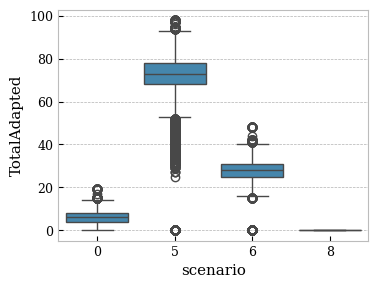

In [5]:
# sns.boxplot(x="policy", y="TotalAdapted", hue="scenario", data=df_all)
sns.boxplot(x="scenario", y="TotalAdapted", data=df_all)

/tmp/ipykernel_216513/2903316645.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=df_end, x="TotalAdapted", hue="policy", kind="kde", col="scenario")


Statistics=507586327.5, p=0.05669033159518881


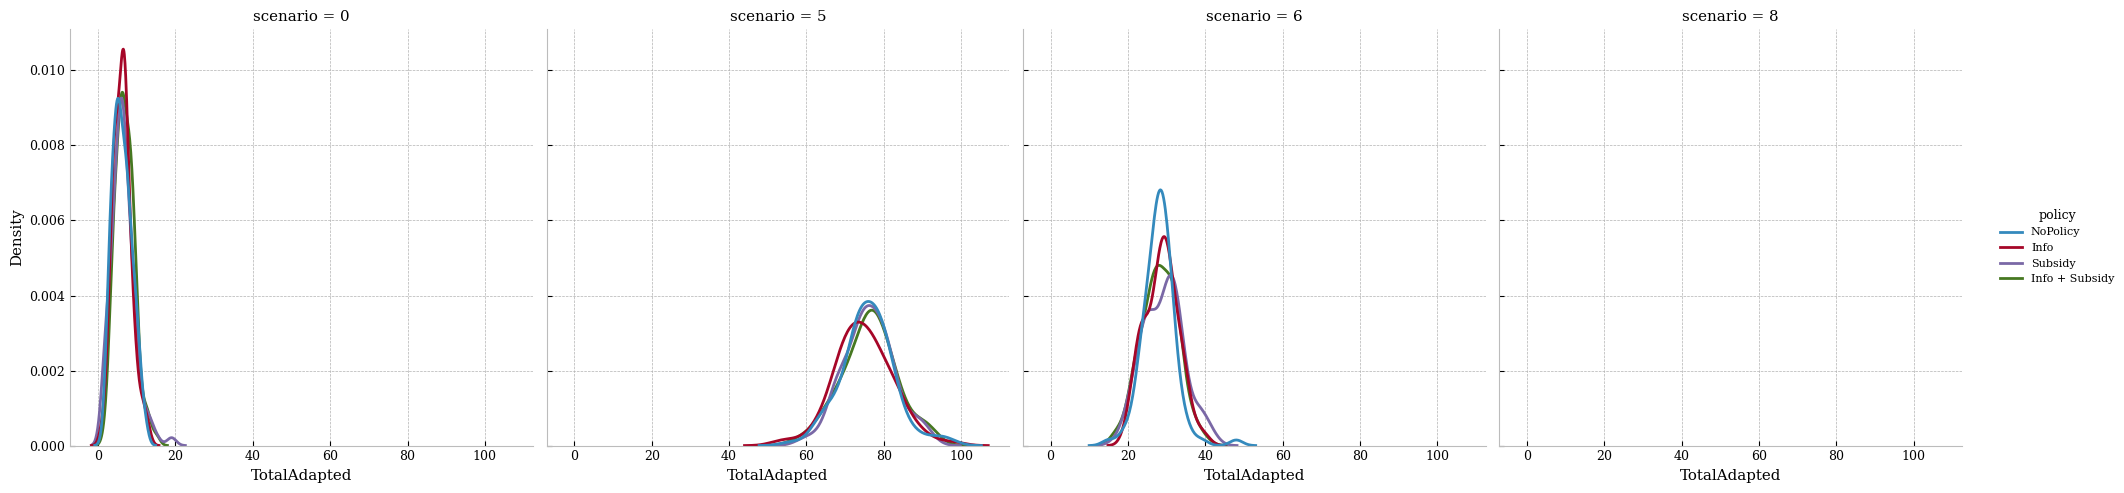

In [6]:
tf = df_all["time"].max()
df_end = df_all[df_all["time"] == tf]


# sns.displot(data=df_end, x="TotalAdapted", hue="policy", kind="kde")
# sns.displot(data=df_end, x="TotalAdapted", hue="scenario", kind="kde", row="policy")
sns.displot(data=df_end, x="TotalAdapted", hue="policy", kind="kde", col="scenario")

stat, p = mannwhitneyu(df_all[df_all["policy"] == "Info"]["TotalAdapted"], df_all[df_all["policy"] == "Subsidy"]["TotalAdapted"])
# stat, p = ttest_ind(df_end[df_all["policy"] == "Info"]["TotalAdapted"], df_end[df_all["policy"] == "Subsidy"]["TotalAdapted"])

print(f"Statistics={stat}, p={p}")

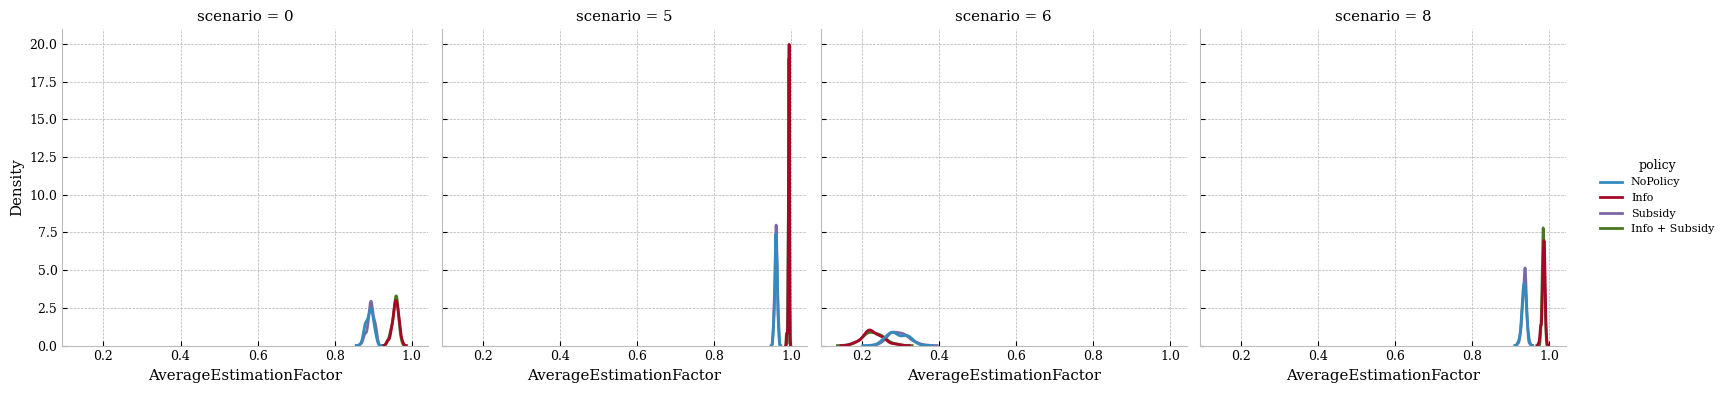

In [7]:
sns.displot(data=df_end, x="AverageEstimationFactor", hue="policy", kind="kde", col="scenario", height=4)

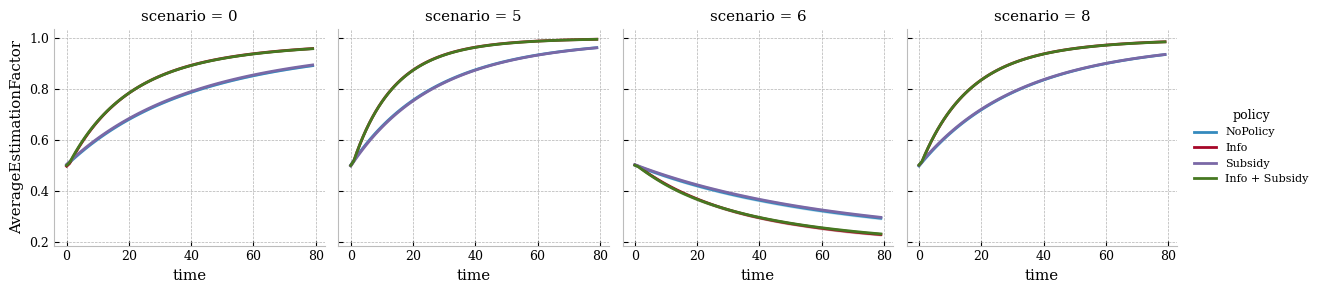

In [8]:
# g = sns.FacetGrid(df_all, col="policy", hue="scenario")
g = sns.FacetGrid(df_all, col="scenario", hue="policy")
g.map(sns.lineplot, "time", "AverageEstimationFactor")
g.add_legend()

# sns.lineplot(data=df_all, x="time", y="AverageEstimationFactor", hue="scenario")


<Axes: xlabel='time', ylabel='TotalAdapted'>

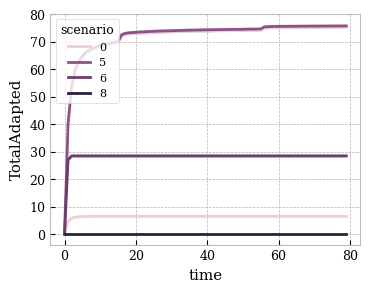

In [9]:
# sns.lineplot(data=df_all, x="time", y="TotalAdapted", hue="policy")
sns.lineplot(data=df_all, x="time", y="TotalAdapted", hue="scenario")




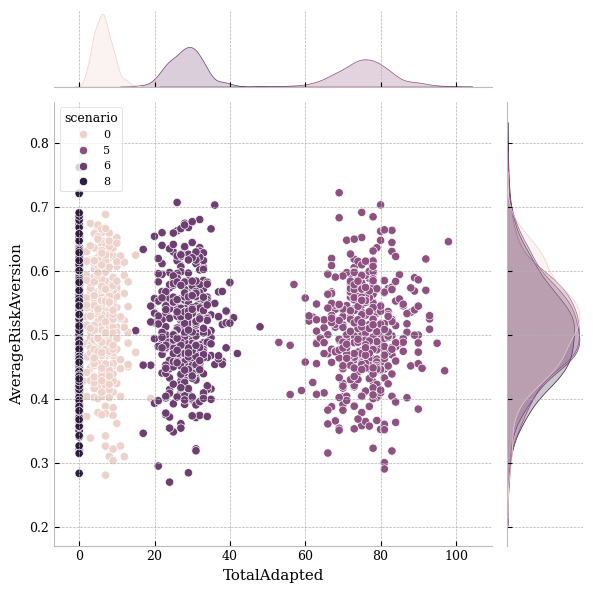

In [10]:
sns.jointplot(data=df_end, x="TotalAdapted", y="AverageRiskAversion", hue="scenario")

/home/simon/miniforge3/envs/abm/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/simon/miniforge3/envs/abm/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/simon/miniforge3/envs/abm/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)


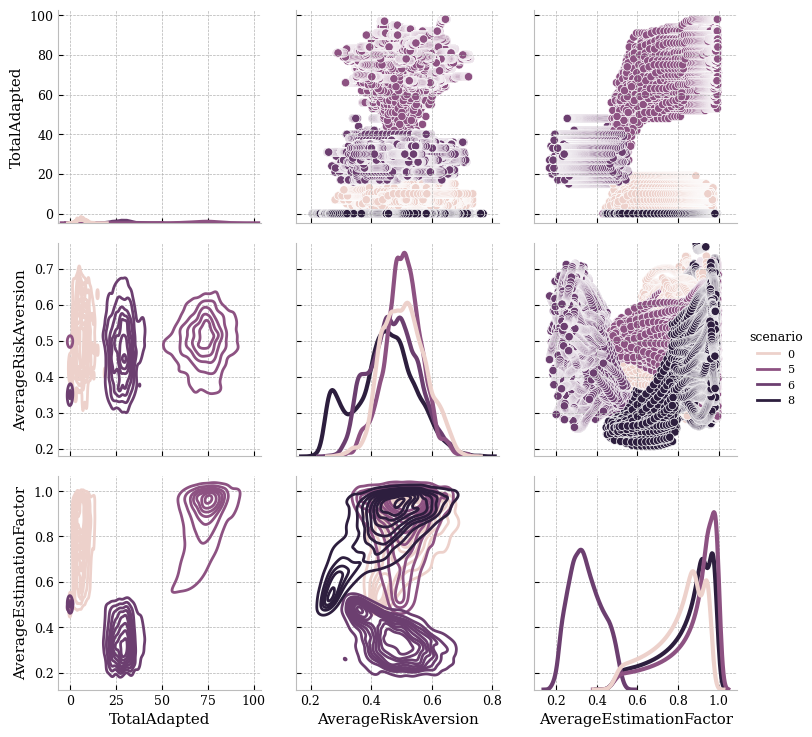

In [14]:
g = sns.PairGrid(df_all, vars=["TotalAdapted", "AverageRiskAversion", "AverageEstimationFactor"], hue="scenario")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.add_legend()

<Axes: xlabel='time', ylabel='SocietalRisk'>

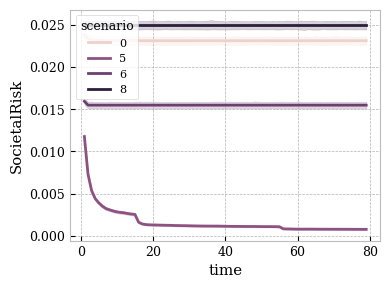

In [100]:
sns.lineplot(data=df_all, x="time", y="SocietalRisk", hue="scenario")


<Axes: xlabel='time', ylabel='InformationAbundance'>

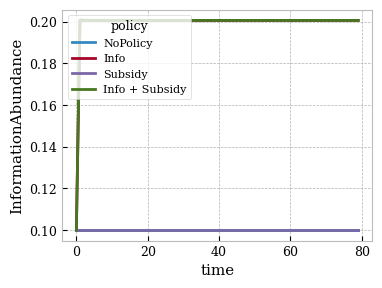

In [94]:
sns.lineplot(data=df_all, x="time", y="InformationAbundance", hue="policy")

<Axes: xlabel='scenario', ylabel='TotalAdapted'>

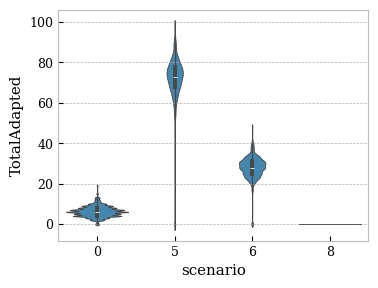

In [13]:
# sns.violinplot(data=df_all, x="policy", y="TotalAdapted")

# plt.figure(figsize=(15, 4))
sns.violinplot(data=df_all, x="scenario", y="TotalAdapted")

States=527447382.0, p=3.8429324842171633e-11


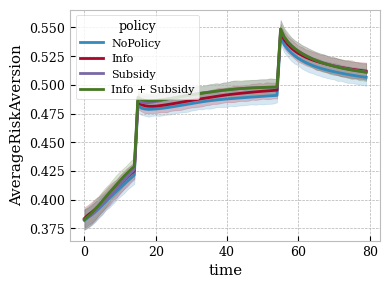

In [96]:
# sns.lineplot(data=df_all, x="time", y="AverageRiskAversion", hue="policy")
sns.lineplot(data=df_all, x="time", y="AverageRiskAversion", hue="scenario")


stat, p = mannwhitneyu(df_all[df_all["policy"] == "Info"]["AverageRiskAversion"], df_all[df_all["policy"] == "NoPolicy"]["AverageRiskAversion"])
print(f"States={stat}, p={p}")

<Axes: xlabel='time', ylabel='AverageEstimationFactor'>

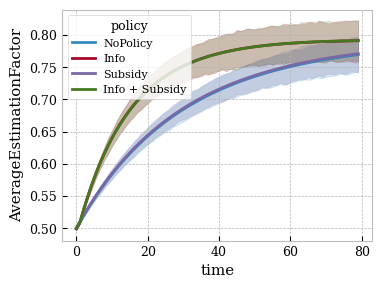

In [97]:
sns.lineplot(data=df_all, x="time", y="AverageEstimationFactor", hue="policy")